In [15]:
""" Import zone """

import math
import html
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer; nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import spacy; spacy_nlp = spacy.load("en_core_web_sm", disable=['ner', 'entity_linker', 'entity_ruler', 'textcat', 'textcat_multilabel', 'morphologizer', 'senter', 'sentencizer', 'transformer'])

from comodo.comodo.comodo import *

import support
register_consts(support.comodo_config)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tommaso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Done → COMODO.COMODO.CONSTANTS in register_consts() → Comodo's costants correctly configured


In [16]:
""" Read DF for analysis """

trdf = DF.set_datetime_index(DF.rcsv('analysis/train_df.csv', sep='\t'), 'date')
trdf.head(2)

,drug,condition,original_review,review,review_words,rating,useful,date,order,review_words_luhn,all_bg,jn_constr,vj_constr,rj_constr,rv_constr,vr_constr
date,,,,,,,,,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,medical clinic flu symptom dr duty prescribe d...,medical clinic flu symptom dr duty prescribe d...,1.0,0,2008-02-24,0,medical clinic flu symptom dr duty know seriou...,symptom dr|flu symptom,NaN,NaN,NaN,symptom dr,flu symptom
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,improve problem dramatically|never experience ...,improve problem dramatically never experience ...,7.0,22,2008-02-24,1,improve dramatically major,experience major|never experience,NaN,experience major,NaN,never experience,NaN


In [17]:
list(LIST.occurrences(trdf.condition).items())[:5]

[('Birth Control', 17595),
 ('Depression', 6024),
 ('Pain', 4224),
 ('Anxiety', 4118),
 ('Acne', 3768)]

In [18]:
""" Raggruppo per condizione """

target_condition = 'ADHD'
gr_condition = trdf.groupby('condition')
grc = gr_condition.get_group(target_condition)

DO_ENTIRE_DATAFRAME = False

grc = trdf.copy() if DO_ENTIRE_DATAFRAME else grc.copy()

<hr style="color: orange">

In [19]:
""" Not empty data index backup """

no_empty_idxs_w = [i for i in range(len(grc['review_words'].to_list())) if type(grc['review_words'][i]) is str and grc['review_words'][i] != '']
no_empty_idxs_wl = [i for i in range(len(grc['review_words_luhn'].to_list())) if type(grc['review_words_luhn'][i]) is str and grc['review_words_luhn'][i]!='']
no_empty_idxs_bg = [i for i in range(len(grc['all_bg'].to_list())) if type(grc['all_bg'][i]) is str and grc['all_bg'][i]!='']
all_bg_unfolded = LIST.lfilter([UTILS.str_replace(bgl, {' ':'000', '|':' '}) for bgl in grc['all_bg'].iloc[no_empty_idxs_bg].to_list() if type(bgl) is str], lambda x: x!='')

<hr style='color: orange'>

<h2>Utility functions</h2>

In [20]:
""" Clustering evaluation functions """

from sklearn.metrics import (rand_score, adjusted_mutual_info_score,
                             homogeneity_score, completeness_score,
                             v_measure_score, fowlkes_mallows_score)

def score_clustering(true_labels, predicted_labels):
  d = {
      "Rand index": rand_score(true_labels, predicted_labels),
      "Adjusted Mutual Info": adjusted_mutual_info_score(true_labels, predicted_labels),
      "Homogeneity": homogeneity_score(true_labels, predicted_labels),
      "Completeness": completeness_score(true_labels, predicted_labels),
      "V measure": v_measure_score(true_labels, predicted_labels),
      "Fowlkes Mallows": fowlkes_mallows_score(true_labels, predicted_labels)
  }
  return d

In [21]:
""" Bigrams functions """

import scipy

def nbgdist(w2v_model, bgs1, bgs2):
    ngvec1 = [bgvec(w2v_model, bg) for bg in bgs1]
    ngvec2 = [bgvec(w2v_model, bg) for bg in bgs2]
    return 1-scipy.spatial.distance.cosine(np.mean(ngvec1, axis=0), np.mean(ngvec2, axis=0))

def bgdist(w2v_model, bg1, bg2):
    gvec1 = bgvec(w2v_model, bg1)
    gvec2 = bgvec(w2v_model, bg2)
    return 1-scipy.spatial.distance.cosine(gvec1, gvec2)

bg_by_concat = lambda vectors: np.concatenate(vectors)
bg_by_mean = lambda vectors: np.mean(vectors, axis=0)
def bgvec(w2v_model, bg, build_function = bg_by_concat):
    vecs = tuple([ML.wvec(w2v_model,g) for g in bg])
    return build_function(vecs)

def all_bigram(review, bigram_cols):
    all_bg = []
    if (False in [review[col]=='' for col in bigram_cols]):
        for bigram_col in bigram_cols:
            if review[bigram_col]!='':
                _ = [all_bg.append(bi.split()) for bi in review[bigram_col].split('|') if bi.split()[0] in w2v_vocab and bi.split()[1] in w2v_vocab]
    return all_bg


<hr style='color: orange'></hr>

<h2>Word2Vec</h2>

In [22]:
""" Loading Models """

w2v_model = UTILS.pkl_load('pkl/w2v_300_NEGnot.pkl')
w2v_vocab = w2v_model.wv.key_to_index

In [23]:
""" Doc to Vectors """

doc_vecs_w = LIST.applyf(grc.iloc[no_empty_idxs_w].review_words, lambda rw: [ML.wvec(w2v_model, w) for w in rw.split() if w in w2v_vocab] if type(rw) is str else [])
no_empty_idxs_w2v_w = [i for i in no_empty_idxs_w if i not in LIST.index_of(doc_vecs_w, [], mode='all')]
doc_vecs_w = LIST.lfilter(doc_vecs_w, lambda dv: dv!=[])

doc_vecs_wl = LIST.applyf(grc.iloc[no_empty_idxs_wl].review_words_luhn, lambda rwl: [ML.wvec(w2v_model, wl) for wl in rwl.split() if wl in w2v_vocab] if type(rwl) is str else [])
no_empty_idxs_w2v_wl = [i for i in no_empty_idxs_wl if i not in LIST.index_of(doc_vecs_wl, [], mode='all')]
doc_vecs_wl = LIST.lfilter(doc_vecs_wl, lambda dv: dv!=[])

doc_vecs_bg = LIST.applyf(all_bg_unfolded, lambda bgs: [bgvec(w2v_model, bg.split('000')) for bg in bgs.split() if False not in [g in w2v_vocab for g in bg.split('000')]])
no_empty_idxs_w2v_bg = [i for i in no_empty_idxs_bg if i not in LIST.index_of(doc_vecs_bg, [], mode='all')]
doc_vecs_bg = LIST.lfilter(doc_vecs_bg, lambda dv: dv!=[])

In [24]:
""" To Single Vector """

single_vec_by_mean = lambda vecs: np.mean(vecs, axis=0)
single_vec_by_median = lambda vecs: np.median(vecs, axis=0)

to_single_vec_function = single_vec_by_mean

doc_vec_w = LIST.applyf(doc_vecs_w, to_single_vec_function)
doc_vec_wl = LIST.applyf(doc_vecs_wl, to_single_vec_function)
doc_vec_bg = LIST.applyf(doc_vecs_bg, to_single_vec_function)

In [25]:
""" Setting Parameters """

lsa_dim = 30 # 50

ag_ks = range(3,6)
kmeans_ks = range(3,6)
gm_ks = range(3,6)

ag_k = 3
kmeans_k = 3
gm_k = 3

In [26]:
""" SVD reduction """

svd_model = TruncatedSVD(n_components=lsa_dim, algorithm='randomized', n_iter=100, random_state=420)

lsa_w2v_w = svd_model.fit_transform(doc_vec_w)
lsa_w2v_wl = svd_model.fit_transform(doc_vec_wl)
lsa_w2v_bg = svd_model.fit_transform(doc_vec_bg)

<hr style='color: orange'>

<h2>Clustering</h2>

In [601]:
""" Agglomerative Clustering """
for ag_k in ag_ks:
    ag_model_w2v_w = AgglomerativeClustering(n_clusters=ag_k, affinity='cosine', linkage='complete')
    agcl_w2v_w = ag_model_w2v_w.fit(lsa_w2v_w)

    ag_model_w2v_wl = AgglomerativeClustering(n_clusters=ag_k, affinity='cosine', linkage='complete')
    agcl_w2v_wl = ag_model_w2v_wl.fit(lsa_w2v_wl)

    ag_model_w2v_bg = AgglomerativeClustering(n_clusters=ag_k, affinity='cosine', linkage='complete')
    agcl_w2v_bg = ag_model_w2v_bg.fit(lsa_w2v_bg)

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_w, list(ag_model_w2v_w.labels_))}
    grc['agglomerative_label_w2v_w_lsa'+str(lsa_dim)+'_k'+str(ag_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_wl, list(ag_model_w2v_wl.labels_))}
    grc['agglomerative_label_w2v_wl_lsa'+str(lsa_dim)+'_k'+str(ag_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_bg, list(ag_model_w2v_bg.labels_))}
    grc['agglomerative_label_w2v_bg_lsa'+str(lsa_dim)+'_k'+str(ag_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

# _ = LIST.describe(list(km_model.labels_), print_res=False, title='Distribuzione label')
# _ = DF.describe(DF.find(grc, {'kmeans_label':1}), 'rating', print_res=False, title='Distribuzione rating su cluster 1'); PLOT.plt.show();
# _ = ML.dist_matrix(DF.find(grc, {'kmeans_label':['!',-1]}).sort_values('kmeans_label')['kmeans_dist'].to_list(), title='Distanza dai centroidi')

In [346]:
""" KMeans """

for kmeans_k in kmeans_ks:
    km_model_w2v_w = KMeans(n_clusters=kmeans_k, random_state=666)
    kmcl_w2v_w = km_model_w2v_w.fit(lsa_w2v_w)

    km_model_w2v_wl = KMeans(n_clusters=kmeans_k, random_state=666)
    kmcl_w2v_wl = km_model_w2v_wl.fit(lsa_w2v_wl)

    km_model_w2v_bg = KMeans(n_clusters=kmeans_k, random_state=666)
    kmcl_w2v_bg = km_model_w2v_bg.fit(lsa_w2v_bg)

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_w, list(km_model_w2v_w.labels_))}
    grc['kmeans_label_w2v_w_lsa'+str(lsa_dim)+'_k'+str(kmeans_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]
    grc['kmeans_dist_w2v_w_lsa'+str(lsa_dim)+'_k'+str(kmeans_k)] = [np.linalg.norm(km_model_w2v_w.cluster_centers_[link_back[order]] - lsa_w2v_w[link_back[order]]) if order in link_back else -1 for order in range(grc.shape[0])]

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_wl, list(km_model_w2v_wl.labels_))}
    grc['kmeans_label_w2v_wl_lsa'+str(lsa_dim)+'_k'+str(kmeans_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]
    grc['kmeans_dist_w2v_wl_lsa'+str(lsa_dim)+'_k'+str(kmeans_k)] = [np.linalg.norm(km_model_w2v_wl.cluster_centers_[link_back[order]] - lsa_w2v_wl[link_back[order]]) if order in link_back else -1 for order in range(grc.shape[0])]

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_bg, list(km_model_w2v_bg.labels_))}
    grc['kmeans_label_w2v_bg_lsa'+str(lsa_dim)+'_k'+str(kmeans_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]
    grc['kmeans_dist_w2v_bg_lsa'+str(lsa_dim)+'_k'+str(kmeans_k)] = [np.linalg.norm(km_model_w2v_bg.cluster_centers_[link_back[order]] - lsa_w2v_bg[link_back[order]]) if order in link_back else -1 for order in range(grc.shape[0])]

# _ = LIST.describe(list(km_model.labels_), print_res=False, title='Distribuzione label')
# _ = DF.describe(DF.find(grc, {'kmeans_label':1}), 'rating', print_res=False, title='Distribuzione rating su cluster 1'); PLOT.plt.show();
# _ = ML.dist_matrix(DF.find(grc, {'kmeans_label':['!',-1]}).sort_values('kmeans_label')['kmeans_dist'].to_list(), title='Distanza dai centroidi')

In [602]:
""" Gaussian Mixture """

for gm_k in gm_ks:
    gm_model_w2v_w = GaussianMixture(n_components=gm_k, random_state=0).fit(lsa_w2v_w)
    gm_w2v_w = gm_model_w2v_w.predict(lsa_w2v_w)

    gm_model_w2v_wl = GaussianMixture(n_components=gm_k, random_state=0).fit(lsa_w2v_wl)
    gm_w2v_wl = gm_model_w2v_wl.predict(lsa_w2v_wl)

    gm_model_w2v_bg = GaussianMixture(n_components=gm_k, random_state=0).fit(lsa_w2v_bg)
    gm_w2v_bg = gm_model_w2v_bg.predict(lsa_w2v_bg)

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_w, gm_w2v_w)}
    grc['mixture_label_w2v_w_lsa'+str(lsa_dim)+'_k'+str(gm_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_wl, gm_w2v_wl)}
    grc['mixture_label_w2v_wl_lsa'+str(lsa_dim)+'_k'+str(gm_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

    link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs_w2v_bg, gm_w2v_bg)}
    grc['mixture_label_w2v_bg_lsa'+str(lsa_dim)+'_k'+str(gm_k)] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

In [603]:
""" Write clustered df output"""

DF.wcsv(grc, 'clustered/bigcl_'+target_condition+'.csv', sep='\t')

<hr style="color:orange">

<h2>Cluster Evaluation<h2>

In [27]:
""" Start from cluster results dataframe """

big_cl = DF.rcsv('clustered/bigcl_'+target_condition+'.csv', sep='\t')
big_cl.head()

,drug,condition,original_review,review,review_words,rating,useful,date,order,review_words_luhn,...,agglomerative_label_w2v_bg_lsa50_k5,mixture_label_w2v_w_lsa50_k3,mixture_label_w2v_wl_lsa50_k3,mixture_label_w2v_bg_lsa50_k3,mixture_label_w2v_w_lsa50_k4,mixture_label_w2v_wl_lsa50_k4,mixture_label_w2v_bg_lsa50_k4,mixture_label_w2v_w_lsa50_k5,mixture_label_w2v_wl_lsa50_k5,mixture_label_w2v_bg_lsa50_k5
0,Methylphenidate,ADHD,my son was taking the mg for yrs when all of a...,son take mg yrs sudden start get severely depr...,son take mg yrs sudden start get severely depr...,5.0,159,2008-02-25,7,son yrs sudden severely depressed thought hurt...,...,0,0,1,0,3,3,1,4,3,2
1,Adderall XR,ADHD,very bad mood swings.,bad mood swing,bad mood swing,4.0,50,2008-02-26,21,swing,...,0,2,0,2,0,1,2,1,0,2
2,Lisdexamfetamine,ADHD,my year old son has taken ritalin strattera an...,year old son take ritalin strattera focalin|fa...,year old son take ritalin strattera focalin fa...,9.0,31,2008-03-02,76,old son ritalin strattera focalin far complain...,...,0,0,1,1,3,3,3,4,3,3
3,Vyvanse,ADHD,i m female adhd tried other medications hated ...,female adhd try medication hate jittery feelin...,female adhd try medication hate jittery feelin...,8.0,95,2008-03-03,94,female adhd hate jittery feeling vyvanse move ...,...,0,0,1,1,3,3,3,2,3,3
4,Strattera,ADHD,i had mild trouble sleeping and developed rayn...,mild trouble sleep develop raynaud year take,mild trouble sleep develop raynaud year take,6.0,35,2008-03-04,97,mild trouble develop raynaud,...,0,1,0,0,0,0,0,0,1,2


In [28]:
""" Obtain cluster evaluation measures """

entries = []
for ld in [30,50]:
    for c in ['w','wl','bg']:
        cdocs = doc_vec_w if c=='w' else doc_vec_wl if c=='wl' else doc_vec_bg
        clsa = TruncatedSVD(n_components=ld, algorithm='randomized', n_iter=100, random_state=420).fit_transform(cdocs), 
        for meth in ['agglomerative', 'mixture']:
            for k in range(3,6):
                cname = meth + '_label_w2v_' + c + '_lsa' + str(ld) +'_k' + str(k)
                clocs = no_empty_idxs_w2v_w if c=='w' else no_empty_idxs_w2v_wl if c=='wl' else no_empty_idxs_bg
                

                clabels = big_cl.iloc[clocs][cname]
                ctruth = big_cl.iloc[clocs].drug
                score = DICT.merge(score_clustering(ctruth, clabels),
                                    {'Silhouette cosine': silhouette_score(clsa[0], clabels, metric='cosine'),
                                    'Silhouette euclidean': silhouette_score(clsa[0], clabels, metric='euclidean')})
                
                entry = [meth, c, ld, k] + list(score.values())
                entries.append(entry)

res = pd.DataFrame(entries, columns= ['method','words','lsa','k'] + list(score.keys()))

In [265]:
""" Observe best models """

mean_cols = ['Silhouette cosine', 'Rand index', 'Fowlkes Mallows']
res['mean'] = res.apply(lambda r: sum(r[mean_cols].values)/3, axis=1)

res.sort_values('mean', ascending=False)[['method','words','lsa','k']+mean_cols+['mean']].head(6)

,method,words,lsa,k,Silhouette cosine,Rand index,Fowlkes Mallows,mean
11,mixture,wl,30,5,0.094215,0.625410,0.138087,0.285904
34,mixture,bg,50,4,0.188395,0.516036,0.151200,0.285210
5,mixture,w,30,5,-0.002431,0.734041,0.123851,0.285154
15,mixture,bg,30,3,0.197278,0.492012,0.154856,0.281382
33,mixture,bg,50,3,0.216111,0.469214,0.157135,0.280820
29,mixture,wl,50,5,0.100726,0.601425,0.138152,0.280101


<h2>Plot measures</h2>

In [29]:
res30 = DF.find_lambda(res, lambda r: r['lsa']==30)
res50 = DF.find_lambda(res, lambda r: r['lsa']==50)

Agglomerative > Rand Index, Silhouette cosine, Fowlkes Mallows
Mixture > Rand Index, Silhouette cosine, Fowlkes Mallows


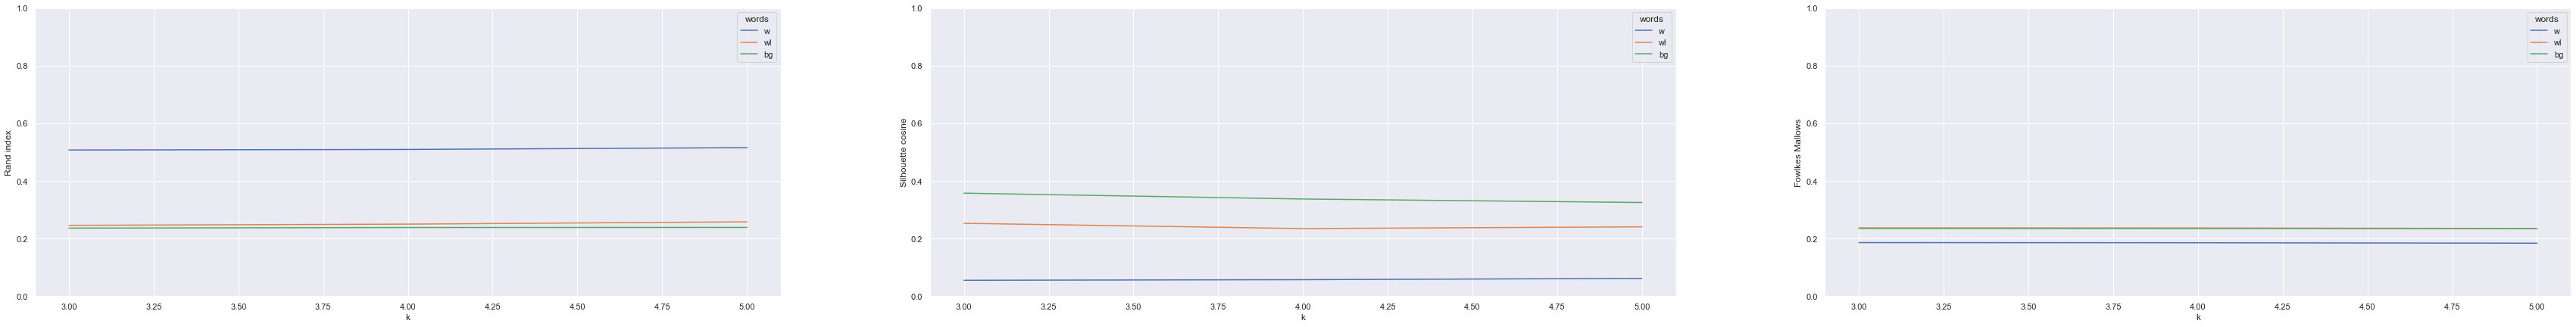

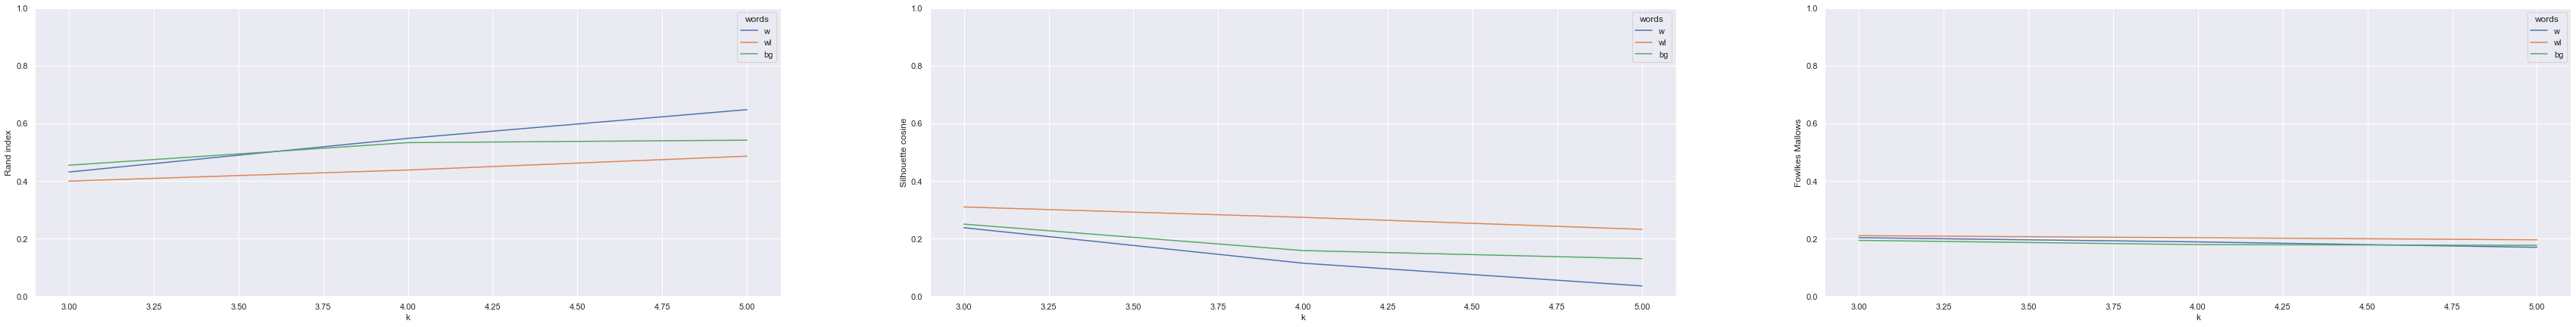

In [31]:
MODULES.set_sns_fsize((60,7))

print('Agglomerative > Rand Index, Silhouette cosine, Fowlkes Mallows')
fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)
sns.lineplot(data=DF.find_lambda(res30, lambda r: 'agglomerative'==r['method']), x='k', y='Rand index', hue='words', ax=ax1);
sns.lineplot(data=DF.find_lambda(res30, lambda r: 'agglomerative'==r['method']), x='k', y='Silhouette cosine', hue='words', ax=ax2);
sns.lineplot(data=DF.find_lambda(res30, lambda r: 'agglomerative'==r['method']), x='k', y='Fowlkes Mallows', hue='words', ax=ax3);
_ = plt.plot()

# print('Kmeans > Rand Index, Silhouette cosine, Fowlkes Mallows')
# fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
# ax1.set_ylim(0,1)
# ax2.set_ylim(0,1)
# ax3.set_ylim(0,1)
# sns.lineplot(data=DF.find_lambda(res30, lambda r: 'kmeans'==r['method']), x='k', y='Rand index', hue='words', ax=ax1);
# sns.lineplot(data=DF.find_lambda(res30, lambda r: 'kmeans'==r['method']), x='k', y='Silhouette cosine', hue='words', ax=ax2);
# sns.lineplot(data=DF.find_lambda(res30, lambda r: 'kmeans'==r['method']), x='k', y='Fowlkes Mallows', hue='words', ax=ax3);
# _ = plt.plot()

print('Mixture > Rand Index, Silhouette cosine, Fowlkes Mallows')
fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)
sns.lineplot(data=DF.find_lambda(res30, lambda r: 'mixture'==r['method']), x='k', y='Rand index', hue='words', ax=ax1);
sns.lineplot(data=DF.find_lambda(res30, lambda r: 'mixture'==r['method']), x='k', y='Silhouette cosine', hue='words', ax=ax2);
sns.lineplot(data=DF.find_lambda(res30, lambda r: 'mixture'==r['method']), x='k', y='Fowlkes Mallows', hue='words', ax=ax3);
_ = plt.plot()

Agglomerative > Rand Index, Silhouette cosine, Fowlkes Mallows
Mixture > Rand Index, Silhouette cosine, Fowlkes Mallows
Bg terza riga migliori


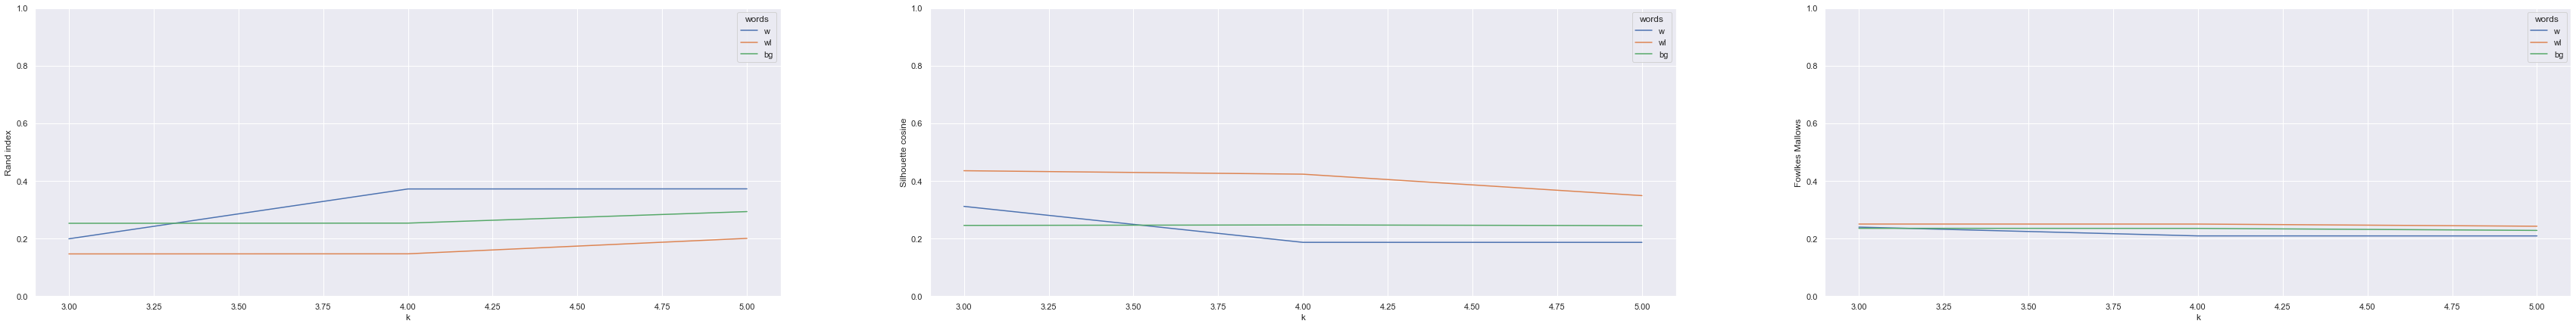

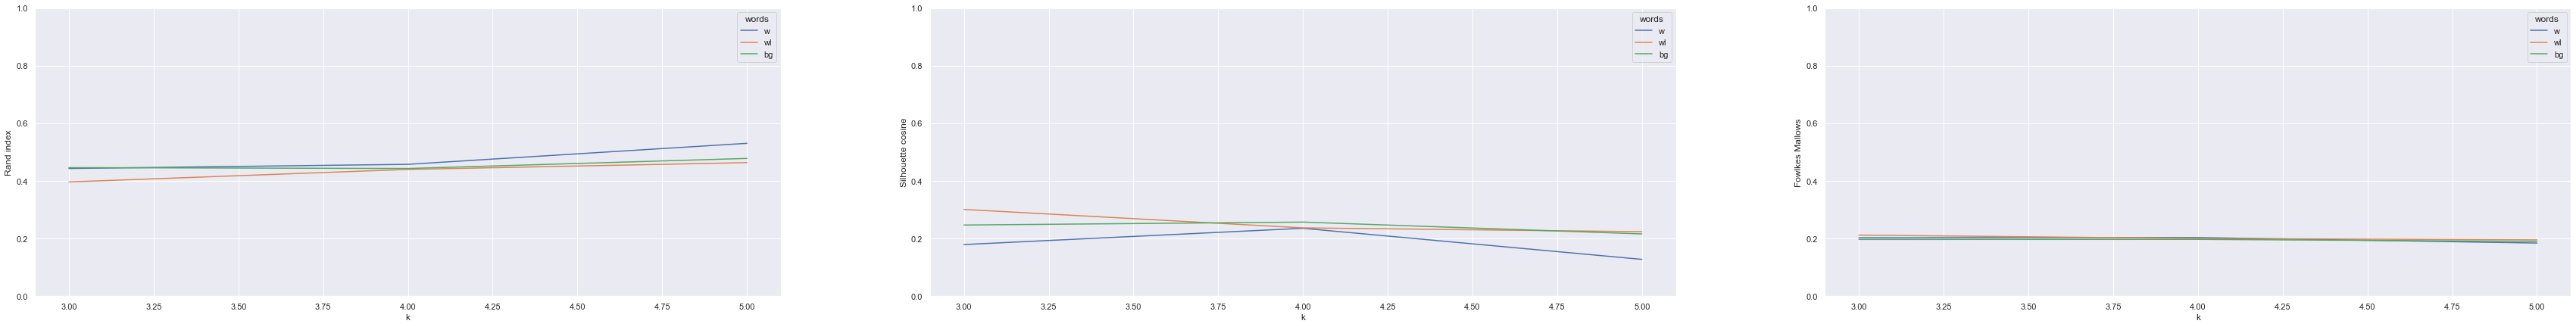

In [32]:
MODULES.set_sns_fsize((60,7))

print('Agglomerative > Rand Index, Silhouette cosine, Fowlkes Mallows')
fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)
sns.lineplot(data=DF.find_lambda(res50, lambda r: 'agglomerative'==r['method']), x='k', y='Rand index', hue='words', ax=ax1);
sns.lineplot(data=DF.find_lambda(res50, lambda r: 'agglomerative'==r['method']), x='k', y='Silhouette cosine', hue='words', ax=ax2);
sns.lineplot(data=DF.find_lambda(res50, lambda r: 'agglomerative'==r['method']), x='k', y='Fowlkes Mallows', hue='words', ax=ax3);
_ = plt.plot()

# print('Kmeans > Rand Index, Silhouette cosine, Fowlkes Mallows')
# fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
# ax1.set_ylim(0,1)
# ax2.set_ylim(0,1)
# ax3.set_ylim(0,1)
# sns.lineplot(data=DF.find_lambda(res50, lambda r: 'kmeans'==r['method']), x='k', y='Rand index', hue='words', ax=ax1);
# sns.lineplot(data=DF.find_lambda(res50, lambda r: 'kmeans'==r['method']), x='k', y='Silhouette cosine', hue='words', ax=ax2);
# sns.lineplot(data=DF.find_lambda(res50, lambda r: 'kmeans'==r['method']), x='k', y='Fowlkes Mallows', hue='words', ax=ax3);
# _ = plt.plot()

print('Mixture > Rand Index, Silhouette cosine, Fowlkes Mallows')
fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)
sns.lineplot(data=DF.find_lambda(res50, lambda r: 'mixture'==r['method']), x='k', y='Rand index', hue='words', ax=ax1);
sns.lineplot(data=DF.find_lambda(res50, lambda r: 'mixture'==r['method']), x='k', y='Silhouette cosine', hue='words', ax=ax2);
sns.lineplot(data=DF.find_lambda(res50, lambda r: 'mixture'==r['method']), x='k', y='Fowlkes Mallows', hue='words', ax=ax3);
_ = plt.plot()

print("Bg terza riga migliori")

In [34]:
""" Choose best method >>>  mixture_label_w2v_bg_lsa30_k3 """

best_meth1 = 'agglomerative_label_w2v_bg_lsa30_k3'
best_meth2 = 'mixture_label_w2v_bg_lsa30_k3'

best_meth = best_meth2
print("Best method chosen is", best_meth)

Best method chosen is mixture_label_w2v_bg_lsa30_k3


<h2>Print interpretation results</h2>

In [35]:
drugs_cl0 = LIST.occurrences(DF.find(big_cl, {best_meth:0})['drug'])
drugs_cl0 = DICT.sort_value({drug: drugs_cl0[drug]/DF.find(big_cl, {'drug':drug, best_meth:['!',-1]}).shape[0] for drug in list(drugs_cl0.keys())}, reverse=True)

drugs_cl1 = LIST.occurrences(DF.find(big_cl, {best_meth:1})['drug'])
drugs_cl1 = DICT.sort_value({drug: drugs_cl1[drug]/DF.find(big_cl, {'drug':drug, best_meth:['!',-1]}).shape[0] for drug in list(drugs_cl1.keys())}, reverse=True)

drugs_cl2 = LIST.occurrences(DF.find(big_cl, {best_meth:2})['drug'])
drugs_cl2 = DICT.sort_value({drug: drugs_cl2[drug]/DF.find(big_cl, {'drug':drug, best_meth:['!',-1]}).shape[0] for drug in list(drugs_cl2.keys())}, reverse=True)

drugs_cl3 = LIST.occurrences(DF.find(big_cl, {best_meth:3})['drug'])
drugs_cl3 = DICT.sort_value({drug: drugs_cl3[drug]/DF.find(big_cl, {'drug':drug, best_meth:['!',-1]}).shape[0] for drug in list(drugs_cl3.keys())}, reverse=True)

drugs_cl4 = LIST.occurrences(DF.find(big_cl, {best_meth:4})['drug'])
drugs_cl4 = DICT.sort_value({drug: drugs_cl4[drug]/DF.find(big_cl, {'drug':drug, best_meth:['!',-1]}).shape[0] for drug in list(drugs_cl4.keys())}, reverse=True)

<h4>Drugs Occurrences</h4>

In [40]:
drug_occurrences = LIST.occurrences(big_cl.iloc[no_empty_idxs_w2v_bg].drug)
_ = [print(d,'-',str(f*100)+'%','out of',drug_occurrences[d]) for d,f in list(drugs_cl0.items())[5:10]]; print()
_ = [print(d,'-',str(f*100)+'%','out of',drug_occurrences[d]) for d,f in list(drugs_cl1.items())[5:10]]; print()
_ = [print(d,'-',str(f*100)+'%','out of',drug_occurrences[d]) for d,f in list(drugs_cl2.items())[5:10]]; print()
# _ = [print(d,'-',str(f*100)+'%','out of',drug_occurrences[d]) for d,f in list(drugs_cl3.items())[:50]]; print()
# _ = [print(d,'-',str(f*100)+'%','out of',drug_occurrences[d]) for d,f in list(drugs_cl4.items())[:50]]; print()

Guanfacine - 26.506024096385545% out of 83
Quillivant XR - 25.0% out of 8
Nuvigil - 25.0% out of 4
Pemoline - 25.0% out of 4
Dyanavel XR - 25.0% out of 4

Amantadine - 100.0% out of 2
Wellbutrin SR - 100.0% out of 1
Pristiq - 100.0% out of 1
Desvenlafaxine - 100.0% out of 1
Selegiline - 100.0% out of 1

Adzenys XR-ODT - 28.57142857142857% out of 7
Adderall XR - 26.31578947368421% out of 57
Quillivant XR - 25.0% out of 8
Pemoline - 25.0% out of 4
Dyanavel XR - 25.0% out of 4



In [41]:
# Vettore medio dei cluster 
vmcl1 = np.mean([doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==0], axis=0)
vmcl2 = np.mean([doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==1], axis=0)
vmcl3 = np.mean([doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==2], axis=0)
# vmcl4 = np.mean([doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==3], axis=0)
# vmcl5 = np.mean([doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==4], axis=0)

In [42]:
top_sim_cl1 = DICT.sort_value({oi:ML.wdist(w2v_vocab, doc_vec, vmcl1) for oi,doc_vec in {i:doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==0}.items()}, reverse=True)
top_sim_cl2 = DICT.sort_value({oi:ML.wdist(w2v_vocab, doc_vec, vmcl2) for oi,doc_vec in {i:doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==1}.items()}, reverse=True)
top_sim_cl3 = DICT.sort_value({oi:ML.wdist(w2v_vocab, doc_vec, vmcl3) for oi,doc_vec in {i:doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==2}.items()}, reverse=True)
# top_sim_cl4 = DICT.sort_value({oi:ML.wdist(w2v_vocab, doc_vec, vmcl4) for oi,doc_vec in {i:doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==3}.items()}, reverse=True)
# top_sim_cl5 = DICT.sort_value({oi:ML.wdist(w2v_vocab, doc_vec, vmcl5) for oi,doc_vec in {i:doc_vec_bg[nei] for nei,i in enumerate(no_empty_idxs_w2v_bg) if big_cl.iloc[i][best_meth]==4}.items()}, reverse=True)

In [43]:
from sklearn.decomposition import PCA
pca_model_300d = PCA(n_components=300).fit(doc_vec_bg)

def pca300_trans(vec):
    return pca_model_300d.transform([vec])[0]

<h4>Cluster representative words</h4>

In [44]:
_ = [print(x) for x in ML.vsim(w2v_model, pca300_trans(vmcl1), topn=10)]; print();
_ = [print(x) for x in ML.vsim(w2v_model, pca300_trans(vmcl2), topn=10)]; print();
_ = [print(x) for x in ML.vsim(w2v_model, pca300_trans(vmcl3), topn=10)]; print(); 
# _ = [print(x) for x in ML.vsim(w2v_model, pca300_trans(vmcl4), topn=10)]; print(); 
# _ = [print(x) for x in ML.vsim(w2v_model, pca300_trans(vmcl5), topn=10)]; print(); 

('remain', 0.15223996341228485)
('huge', 0.12914153933525085)
('affect', 0.12762483954429626)
('hence', 0.12555858492851257)
('abilify', 0.12274007499217987)
('helpful', 0.12003529816865921)
('perfect', 0.11904538422822952)
('disability', 0.11883724480867386)
('not_completely', 0.11816953867673874)
('effectively', 0.11756002902984619)

('drop', 0.15017986297607422)
('not_control', 0.15008820593357086)
('ridiculously', 0.1488945484161377)
('often', 0.14696183800697327)
('sky_rocket', 0.14313152432441711)
('anymore', 0.1422988921403885)
('uninterested', 0.1408383548259735)
('tired', 0.13693667948246002)
('libido', 0.13611441850662231)
('therefore', 0.13586482405662537)

('describe', 0.1923074871301651)
('explain', 0.18432378768920898)
('thick', 0.17441628873348236)
('heavy', 0.17327921092510223)
('bath', 0.16245540976524353)
('shape', 0.16164922714233398)
('heroin', 0.15273073315620422)
('expect', 0.15256398916244507)
('heat', 0.14761123061180115)
('lip', 0.1472885012626648)



<h4>Cluster representative review's bigrams</h4>

In [45]:
print(big_cl.iloc[list(top_sim_cl1.keys())[:2]].all_bg.values); print()
print(big_cl.iloc[list(top_sim_cl2.keys())[:2]].all_bg.values); print()
print(big_cl.iloc[list(top_sim_cl3.keys())[:2]].all_bg.values); print()
# print(big_cl.iloc[list(top_sim_cl4.keys())[:2]].all_bg.values); print()
# print(big_cl.iloc[list(top_sim_cl5.keys())[:2]].all_bg.values); print()

['old son|confirm suspicion|child behavior|zombie people|start confirm|start usual|become zombie|mild strattera|strattera concerta|mg miracle'
 'old son|make behavior|xr morning|release school|later afternoon|switch ritalin|mg xr|switch personality|mg non|go make|literally see|focus homework|medication go|mg focus']

['adult patch|stimulant bearable|tough long|pick tendency|even want|talk people|alone stare|real problem|daytrana patch|whole hour|much day|feel absence|guilt embarrassment|pick cuticle|completely drain|shower bath|crash extreme|remember similar|leave whole|increase dopamine|happiness not_feel|high feel|increase urge|think slowly|actually adult|right stimulant|find stimulant|try daytrana|also desperate|also less|get necessary|pretty much|not_anymore repetitive|degree sadness|far negative|anxiety depression|calm weird|far take|tell suffer|never crash|anti depressant|appetite increase|depressed irritable|twice throw|suffer anxiety|fast get|etc effortlessly|double anti'
 'sev

<h4>Cluster representative bigrams</h4>

In [46]:
bg_cl1 = set(); _ = [[bg_cl1.add(bg) for bg in bgs.split('|')] for bgs in big_cl.iloc[list(top_sim_cl1.keys())].all_bg]; bg_cl1 = list(bg_cl1);
_ = [print(bg) for bg in list(DICT.sort_value({bg:ML.wdist(w2v_model, bgvec(w2v_model, bg[0].split()), pca300_trans(vmcl1)) if bg[0] in w2v_vocab and bg[1] in w2v_vocab else -1 for bg in bg_cl1}, reverse=True).items())[:10]]; print()

bg_cl2 = set(); _ = [[bg_cl2.add(bg) for bg in bgs.split('|')] for bgs in big_cl.iloc[list(top_sim_cl2.keys())].all_bg]; bg_cl2 = list(bg_cl2);
_ = [print(bg) for bg in list(DICT.sort_value({bg:ML.wdist(w2v_model, bgvec(w2v_model, bg[0].split()), pca300_trans(vmcl2)) if bg[0] in w2v_vocab and bg[1] in w2v_vocab else -1 for bg in bg_cl2}, reverse=True).items())[:10]]; print()

bg_cl3 = set(); _ = [[bg_cl3.add(bg) for bg in bgs.split('|')] for bgs in big_cl.iloc[list(top_sim_cl3.keys())].all_bg]; bg_cl3 = list(bg_cl3);
_ = [print(bg) for bg in list(DICT.sort_value({bg:ML.wdist(w2v_model, bgvec(w2v_model, bg[0].split()), pca300_trans(vmcl3)) if bg[0] in w2v_vocab and bg[1] in w2v_vocab else -1 for bg in bg_cl3}, reverse=True).items())[:10]]; print()

# bg_cl4 = set(); _ = [[bg_cl4.add(bg) for bg in bgs.split('|')] for bgs in big_cl.iloc[list(top_sim_cl4.keys())].all_bg]; bg_cl4 = list(bg_cl4);
# _ = [print(bg) for bg in list(DICT.sort_value({bg:ML.wdist(w2v_model, bgvec(w2v_model, bg[0].split()), pca300_trans(vmcl3)) if bg[0] in w2v_vocab and bg[1] in w2v_vocab else -1 for bg in bg_cl4}, reverse=True).items())[:10]]; print()

# bg_cl5 = set(); _ = [[bg_cl5.add(bg) for bg in bgs.split('|')] for bgs in big_cl.iloc[list(top_sim_cl5.keys())].all_bg]; bg_cl5 = list(bg_cl5);
# _ = [print(bg) for bg in list(DICT.sort_value({bg:ML.wdist(w2v_model, bgvec(w2v_model, bg[0].split()), pca300_trans(vmcl3)) if bg[0] in w2v_vocab and bg[1] in w2v_vocab else -1 for bg in bg_cl5}, reverse=True).items())[:10]]; print()

('fully function', 0.11365223978598016)
('flavor hate', 0.11365223978598016)
('full time', 0.11365223978598016)
('quit cold', 0.05509121202497602)
('quickly medication', 0.05509121202497602)
('blind temple', 0.03830688075936095)
('break bad', 0.03830688075936095)
('black eye', 0.03830688075936095)
('put dosage', 0.02443166261237817)
('pulmonary hypertension', 0.02443166261237817)

('grade fine', 0.07668924652866749)
('grow eventually', 0.07668924652866749)
('great school', 0.07668924652866749)
('grade really', 0.07668924652866749)
('graduate age', 0.07668924652866749)
('great drug', 0.07668924652866749)
('grade always', 0.07668924652866749)
('guess small', 0.07668924652866749)
('glad decide', 0.07668924652866749)
('grow always', 0.07668924652866749)

('university minor', 0.04955549796580161)
('unfortunately medication', 0.04955549796580161)
('ur social', 0.04955549796580161)
('unhappy life', 0.04955549796580161)
('crazy super', 0.027802537484785006)
('cranky accord', 0.0278025374847850

<h4>Plot space in PCA</h4>

In [47]:
from sklearn.decomposition import PCA
pca_model_2d = PCA(n_components=3).fit(doc_vec_bg)

def pca2_trans(vec):
    return pca_model_2d.transform([vec])[0]

doc_vec_bg_pca = pca_model_2d.transform(doc_vec_bg)
cl_centers_pca = pca_model_2d.transform([vmcl1, vmcl2, vmcl3])

C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the futu

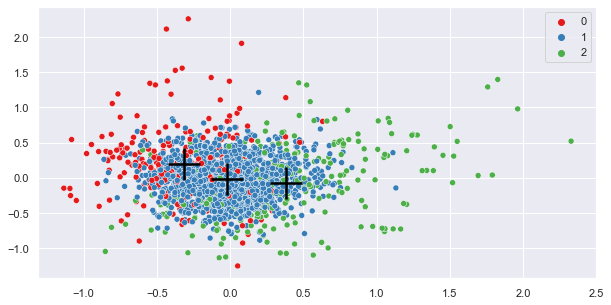

In [48]:
MODULES.set_sns_fsize((10,5))
sns.scatterplot(doc_vec_bg_pca[:,0], doc_vec_bg_pca[:,1], hue=big_cl.iloc[no_empty_idxs_w2v_bg][best_meth], palette=sns.color_palette("Set1", n_colors=3));
sns.scatterplot(cl_centers_pca[:,0], cl_centers_pca[:,1], marker='+', color='black', s=1000);

In [49]:
""" 3D Scatter """
scatter_x = doc_vec_bg_pca[:, 0]
scatter_y = doc_vec_bg_pca[:, 1]
scatter_z = doc_vec_bg_pca[:, 2]
px.scatter_3d(x=scatter_x, y=scatter_y, z=scatter_z, color=big_cl.iloc[no_empty_idxs_w2v_bg].rating)

<hr>